In [6]:
from tqdm import tqdm
import torch
from torch import nn, optim
import torch.nn.functional as F
import math
from matplotlib import pyplot
import numpy as np
from numpy import inf

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [7]:
from pathlib import Path
import requests
import pickle
import struct
import gzip
import io
import time

In [18]:
from pysrc import zipper
from pysrc import torchQuant
from pysrc.nanoTorch import *

In [8]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

m = nn.AvgPool2d(2, stride=2)
x_train = m(x_train.reshape((50000, 28, 28))).reshape((50000, 14 * 14))
x_valid = m(x_valid.reshape((10000, 28, 28))).reshape((10000, 14 * 14))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 196])
tensor(0) tensor(9)
torch.Size([50000, 196])
torch.Size([10000, 196])


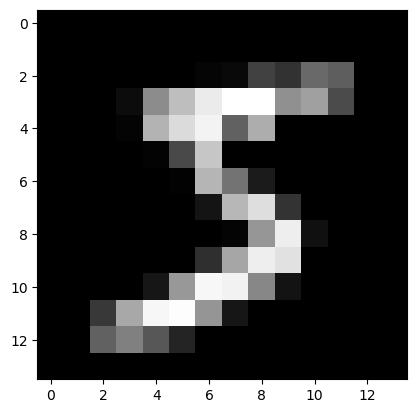

In [9]:
bs = 64  # batch size

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

pyplot.imshow(x_train[0].reshape((round(math.sqrt(c)), round(math.sqrt(c)))), cmap="gray")
print(x_train.shape)
print(x_valid.shape)

In [13]:
x_train = torchQuant.Q_int8(x_train, torch.max(torch.abs(x_train))/(16-1), 0)
x_valid = torchQuant.Q_int8(x_valid, torch.max(torch.abs(x_valid))/(16-1), 0)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])


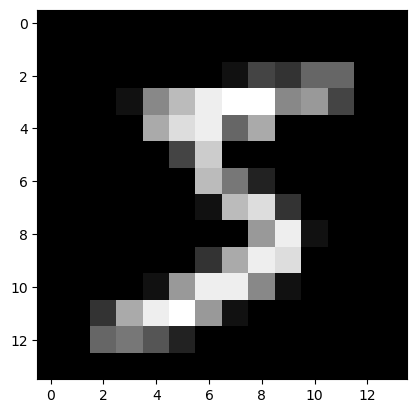

In [14]:
pyplot.imshow(x_train[0].reshape((14, 14)), cmap="gray")
print(x_train, y_train)

In [15]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

In [19]:
class MNIST_Model_Q(nn.Module):
  def __init__(self, h1):
    super().__init__()
    self.l1 = torchQuant.FC_Q(c, h1)
    self.l2 = torchQuant.FC_Q(h1, 10)
    #self.l3 = FC_Q(10, 10)

  def forward(self, xb, train = True, L1_w = 256, L1_x = 256, L2_w = 256, L2_x = 256):
    act = torch.nn.ReLU6()
    out_act = torch.nn.Softmax(dim=1)
    L1 = act(self.l1(xb, train, L1_w, L1_x))
    L2 = self.l2(L1, train, L2_w, L2_x)
    '''
    if verbose:
      print(torch.transpose(Q_int8(L1, self.l2.s_x(L2_bits), 0).type(torch.uint8), 0, 1))
      print(torch.transpose(L2, 0, 1))
    '''
    return out_act(L2)

  def compile(self, input, output, L1_bits = 8, L2_bits = 8):
    begin = op(OP_BEGIN, input.to(torch.int8))
    next = op(OP_MATMUL, self.l1.s_w(self.w_bits).to(torch.int8), begin)
    next = op(OP_MATRIX_ADD, input.to(torch.int8), next)
    next = op(OP_DEQUANTIZE, input.to(torch.int8), next)

    next = op(OP_MATRIX_MAX, input.to(torch.int8), next)

    next = op(OP_QUANTIZE, torch.tensor(1, dtype=torch.float32), next)
    next = op(OP_MATMUL, input.to(torch.int8), next)
    next = op(OP_MATRIX_ADD, input.to(torch.int8), next)
    next = op(OP_DEQUANTIZE, input.to(torch.int8), next)

    op(OP_END, output.to(torch.int8), next)

    return begin.emit()

In [20]:
lr = 0.001  # learning rate
epochs = 20  # how many epochs to train for
loss_func = F.cross_entropy
hidden_dim = 64

def get_model():
    model = MNIST_Model_Q(hidden_dim)
    return model, optim.Adam(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(x_valid[0:bs]), y_valid[0:bs]))

tensor(2.2878, grad_fn=<NllLossBackward0>)


In [21]:
# Create fit() and get_data()
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
        if (epoch % 5 == 0):
            model.eval()
            with torch.no_grad():
                losses, nums = zip(
                    *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
                )
            val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            print(epoch, val_loss)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 1.5341457502365112
5 1.5000014377593993
10 1.494249535369873
15 1.4940118537902831


In [22]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean().item()

def correct_index(out, yb):
    preds = torch.argmax(out, dim=1)
    return torch.nonzero((preds == yb), as_tuple = True)

In [23]:
L1_bits = 6 # 5 for 28*28, 9 for 14*14
L2_bits = 8
print("Unquantized accuracy", accuracy(model(x_valid), y_valid), "%")
print("Quantized accuracy int8", accuracy(model(x_valid, train = False,
                                                L1_w = 16, L1_x = 2,
                                                L2_w = 12, L2_x = 4),
                                          y_valid), "%")
print("Quantized accuracy int8", accuracy(model(x_valid, train = False,
                                                L1_w = 14, L1_x = 10,
                                                L2_w = 8, L2_x = 7),
                                          y_valid), "%")

Unquantized accuracy 0.9688000082969666 %
Quantized accuracy int8 0.8809999823570251 %
Quantized accuracy int8 0.9294999837875366 %
